## Model Interpretability with SHAP

In healthcare applications, model transparency is essential to build trust and ensure that predictions align with established clinical knowledge.

SHAP (SHapley Additive exPlanations) values were used to explain individual predictions and to validate whether the model’s decision-making process prioritizes clinically meaningful risk factors.


## Model Interpretation and Clinical Alignment

The SHAP analysis confirms that the model prioritizes clinically well-established risk factors for diabetes. Variables related to metabolic health, such as high blood pressure, high cholesterol, and body mass index, appear as the strongest contributors to positive predictions.

Age-related features also play a significant role, reflecting the increasing prevalence of diabetes across older populations. Importantly, the model does not rely heavily on purely behavioral variables, which are often subject to reporting bias, but instead focuses on physiological indicators that align with medical understanding of disease progression.

This alignment between model behavior and clinical knowledge increases confidence in the system’s suitability as a screening tool, as predictions are driven by meaningful health signals rather than spurious correlations.


In [6]:
import sys
import os

# Add project root to Python path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

In [7]:
import shap
import pandas as pd
from src.preprocessing import basic_cleaning, engineer_features, prepare_train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

df = pd.read_csv("../data/diabetes_binary_health_indicators_BRFSS2015.csv")

df_clean = basic_cleaning(df)
df_fe = engineer_features(df_clean)
X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_train_test_split(df_fe, 'Diabetes_binary', 0.2, 42)

ratio = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric="logloss"
)

xgb_model.fit(X_train_scaled, y_train)
y_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.3
y_pred_xgb = (y_probs >= threshold).astype(int)

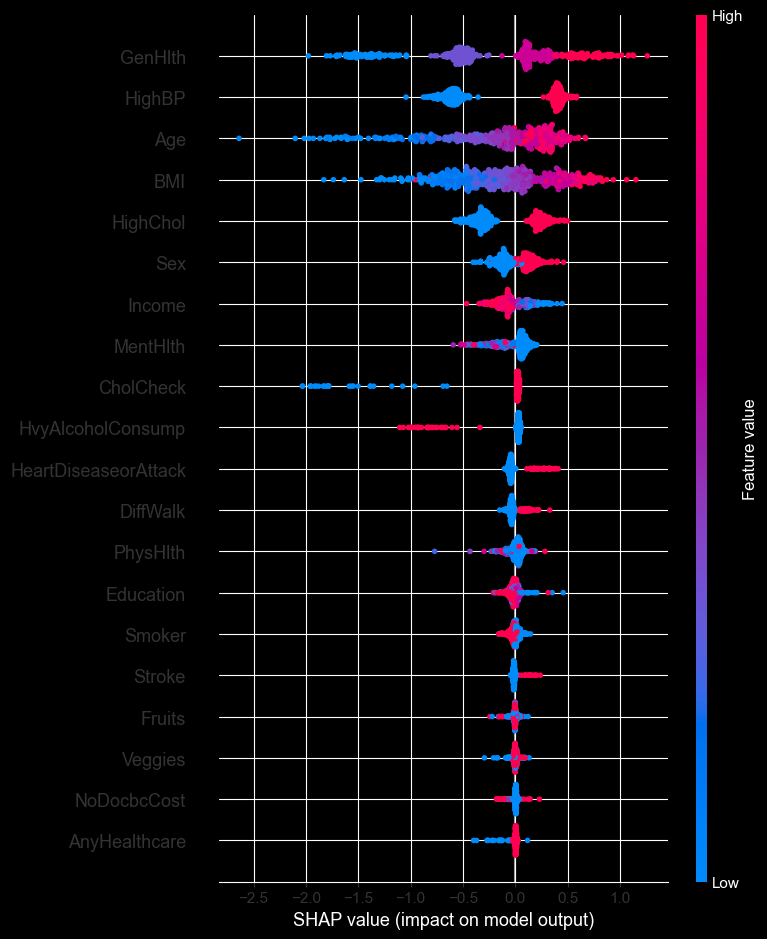

In [9]:
explainer = shap.TreeExplainer(xgb_model)

feature_names = df_fe.drop("Diabetes_binary", axis=1).columns

X_test_sample = pd.DataFrame(
    X_test_scaled,
    columns=feature_names
).sample(500, random_state=42)

shap_values = explainer.shap_values(X_test_sample)

shap.summary_plot(shap_values, X_test_sample)

## Conclusion

This project demonstrates how machine learning can be applied responsibly as an early-stage diabetes screening tool. By prioritizing recall and explicitly managing the trade-off between false positives and false negatives, the model aligns with real-world clinical decision-making processes.

Rather than aiming for diagnostic certainty, the system functions as a risk-based triage mechanism, identifying individuals who should be prioritized for further medical evaluation. The use of interpretable models and transparent decision thresholds ensures that predictions remain explainable and clinically meaningful.

Overall, the project highlights the importance of aligning modeling choices with domain constraints, emphasizing that successful healthcare applications require not only strong performance metrics but also contextual awareness and interpretability.
